In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd

# Keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

# Standard ML stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

# Oversampling of minority class 'Churn customers'
from imblearn.over_sampling import SMOTE

# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Helper functions

In [2]:
def get_keras_dataset(df):
    X = {str(col) : np.array(df[col]) for col in df.columns}
    return X

In [3]:
# Plot the results of the training
def plot_history(history):
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    
    plt.xlabel('Epoch')
    plt.ylabel('loss, acc')
    
    # Losses
    ax.plot(history.epoch, history.history['loss'], label='Train LOSS')
    ax.plot(history.epoch, history.history['val_loss'], label='Val LOSS')
    ax.plot(history.epoch, history.history['acc'], label ='Train Accuracy')
    ax.plot(history.epoch, history.history['val_acc'], label='Val Accuracy')
    plt.legend()
    
    # Plot the learning_rate
    if 'lr' in history.history:
        ax = plt.subplot(212)
        plt.ylabel('Learning rate')
        ax.plot(history.epoch, history.history['lr'], label='learning_rate')
        plt.legend()
    plt.show()
    plt.close(fig)

# Load the dataset

In [4]:
# Load the dataset
telcom = pd.read_csv("../input/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data preparation

## Replace space characters with nan

In [5]:
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)
print("Missing values in TotalCharges: ", telcom["TotalCharges"].isnull().sum())

telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]
print("Missing values in TotalCharges: ", telcom["TotalCharges"].isnull().sum())

telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)
print("dType TotalCharges: ", telcom['TotalCharges'].dtype)

Missing values in TotalCharges:  11
Missing values in TotalCharges:  0
dType TotalCharges:  float64


## Create categories for integer values 

In [6]:
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes", 0:"No"})

## Group customers by tenure

In [7]:
def tenure_lab(telcom) :
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
    
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom), axis=1)

## Extract different feature groups

In [8]:
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
target_col = ['Churn']
ignored_cols = ['customerID']
categorical_cols = telcom.select_dtypes(include='object').columns
categorical_cols = [col for col in categorical_cols if col not in target_col + ignored_cols]

## Encode the categorical features + target variable

In [9]:
for col in categorical_cols:
    telcom[col] = LabelEncoder().fit_transform(telcom[col])

telcom['Churn'] = telcom['Churn'].map({'Yes' : 1, 'No' : 0})

## Transform the numeric features

In [10]:
telcom[numeric_cols] = StandardScaler().fit_transform(telcom[numeric_cols])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Add low dim representations as additional features

In [11]:
pca = PCA(n_components=3)
_X = pca.fit_transform(telcom[numeric_cols + categorical_cols])
pca_data = pd.DataFrame(_X, columns=["PCA1", "PCA2", "PCA3"])
telcom[["PCA1", "PCA2", "PCA3"]] = pca_data

fica = FastICA(n_components=3)
_X = fica.fit_transform(telcom[numeric_cols + categorical_cols])
fica_data = pd.DataFrame(_X, columns=["FICA1", "FICA2", "FICA3"])
telcom[["FICA1", "FICA2", "FICA3"]] = fica_data

tsvd = TruncatedSVD(n_components=3)
_X = tsvd.fit_transform(telcom[numeric_cols + categorical_cols])
tsvd_data = pd.DataFrame(_X, columns=["TSVD1", "TSVD2", "TSVD3"])
telcom[["TSVD1", "TSVD2", "TSVD3"]] = tsvd_data

grp = GaussianRandomProjection(n_components=3)
_X = grp.fit_transform(telcom[numeric_cols + categorical_cols])
grp_data = pd.DataFrame(_X, columns=["GRP1", "GRP2", "GRP3"])
telcom[["GRP1", "GRP2", "GRP3"]] = grp_data

srp = SparseRandomProjection(n_components=3)
_X = srp.fit_transform(telcom[numeric_cols + categorical_cols])
srp_data = pd.DataFrame(_X, columns=["SRP1", "SRP2", "SRP3"])
telcom[["SRP1", "SRP2", "SRP3"]] = srp_data

#tsne = TSNE(n_components=3)
#_X = tsne.fit_transform(telcom[numeric_cols + categorical_cols])
#tsne_data = pd.DataFrame(_X, columns=["TSNE1", "TSNE2", "TSNE3"])
#telcom[["TSNE1", "TSNE2", "TSNE3"]] = tsne_data

numeric_cols.extend(pca_data.columns.values)
numeric_cols.extend(fica_data.columns.values)
numeric_cols.extend(tsvd_data.columns.values)
numeric_cols.extend(grp_data.columns.values)
numeric_cols.extend(srp_data.columns.values)
#numeric_cols.extend(tsne_data.columns.values)

## Split dataset in a traning and evaluation part

In [12]:
train_df, test_df = train_test_split(telcom, test_size=0.15, random_state=42)
print(train_df.shape)

(5977, 37)


In [27]:
train_df.head()

,MonthlyCharges,TotalCharges,tenure,PCA1,PCA2,PCA3,FICA1,FICA2,FICA3,TSVD1,TSVD2,TSVD3,GRP1,GRP2,GRP3,SRP1,SRP2,SRP3,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure_group,Churn
0,1.347960,-0.864750,-1.198760,-0.864656,-2.584120,-0.433701,0.006689,-0.020837,-0.011953,3.073166,1.082946,-2.632647,-0.249218,-1.085486,-0.509247,-6.529576,-2.441894,-1.055814,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1
1,-0.452010,-0.318449,-0.098673,0.021140,-0.247893,-0.112500,-0.000236,-0.002414,-0.001051,3.281587,0.224392,-0.212418,2.766314,-0.405234,-1.793652,-1.890013,0.000000,-0.388810,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,1.0,2.0,1
2,0.350746,-0.017383,-0.139417,0.786138,-0.463589,-0.395671,-0.003484,-0.006539,0.000385,3.698884,-0.460068,-0.382040,0.567281,0.780962,-1.466986,-4.091084,-3.662842,2.420671,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,0
3,-1.469168,-0.642369,0.308766,0.242802,1.996985,0.455683,-0.003271,0.017302,0.007981,3.593796,0.221895,2.078431,2.779679,3.510792,-0.671947,-1.869065,-2.441894,0.436648,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,0
4,0.726363,1.681343,1.612573,4.161336,-0.032100,-0.464256,-0.011375,-0.009867,0.015857,6.503979,-2.450789,-0.032241,1.204193,-1.191187,-0.061499,-5.770640,-1.220947,4.494726,1.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,4.0,0


## SMOTE oversampling of minority class

In [13]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
os_smote_X, os_smote_Y = smote.fit_sample(train_df[numeric_cols + categorical_cols], train_df[target_col].values.ravel())

train_df = pd.DataFrame(os_smote_X, columns=numeric_cols + categorical_cols)
train_df['Churn'] = os_smote_Y
print(train_df.shape)

(8784, 36)


In [14]:
os_smote_X

array([[ 1.34795954, -0.86474969, -1.19876011, ...,  1.        ,
         0.        ,  0.        ],
       [-0.45201047, -0.31844931, -0.09867316, ...,  0.        ,
         1.        ,  2.        ],
       [ 0.35074624, -0.01738298, -0.13941712, ...,  1.        ,
         0.        ,  2.        ],
       ...,
       [ 0.65389756, -0.8070656 , -1.1169971 , ...,  0.99774939,
         2.        ,  0.        ],
       [ 0.70749714, -0.94265867, -1.24343673, ...,  1.        ,
         2.        ,  0.        ],
       [ 0.22207429, -0.97582787, -1.28024804, ...,  1.        ,
         3.        ,  0.        ]])

## Delete the CustomerID

In [15]:
customer_id = telcom['customerID']
telcom = telcom.drop('customerID', axis=1)

# Begin the modelling process

In [16]:
K.clear_session()


### Define global parameters

In [17]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

FEATURE_COLS = numeric_cols + categorical_cols
TARGET_COL = 'Churn'
EPOCHS = 500
BATCH_SIZE = 100000
CLASS_WEIGHTS = {0 : 1., 1 : 2.5}

### Placeholders for the model input and embedding layers

In [18]:
cat_inputs = []
num_inputs = []
embeddings = []
embedding_layer_names = []
emb_n = 10

### Keras model architecture

In [19]:
# Embedding for categorical features
for col in categorical_cols:
    _input = layers.Input(shape=[1], name=col)
    _embed = layers.Embedding(telcom[col].max() + 1, emb_n, name=col+'_emb')(_input)
    cat_inputs.append(_input)
    embeddings.append(_embed)
    embedding_layer_names.append(col+'_emb')
    
# Simple inputs for the numeric features
for col in numeric_cols:
    numeric_input = layers.Input(shape=(1,), name=col)
    num_inputs.append(numeric_input)
    
# Merge the numeric inputs
merged_num_inputs = layers.concatenate(num_inputs)
#numeric_dense = layers.Dense(20, activation='relu')(merged_num_inputs)

# Merge embedding and use a Droput to prevent overfittting
merged_inputs = layers.concatenate(embeddings)
spatial_dropout = layers.SpatialDropout1D(0.2)(merged_inputs)
flat_embed = layers.Flatten()(spatial_dropout)

# Merge embedding and numeric features
all_features = layers.concatenate([flat_embed, merged_num_inputs])

# MLP for classification
x = layers.Dropout(0.2)(layers.Dense(100, activation='relu')(all_features))
x = layers.Dropout(0.2)(layers.Dense(50, activation='relu')(x))
x = layers.Dropout(0.2)(layers.Dense(25, activation='relu')(x))
x = layers.Dropout(0.2)(layers.Dense(15, activation='relu')(x))

# Final model
output = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=cat_inputs + num_inputs, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile model with all parameters

In [26]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gender (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
SeniorCitizen (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
Partner (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
Dependents (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
PhoneServi

### Definition model callbacks

In [21]:
# TB Callback
log_folder = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
tb_callback = callbacks.TensorBoard(
    log_dir=os.path.join('tb-logs', log_folder),
)

# Best model callback
bm_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join('tb-logs', log_folder, 'bm.h5'),
    save_best_only=True,
    save_weights_only=False
)

### Training

In [22]:
_hist = model.fit(
    x=get_keras_dataset(train_df[FEATURE_COLS]),
    y=train_df[TARGET_COL],
    validation_data=(get_keras_dataset(test_df[FEATURE_COLS]), test_df[TARGET_COL]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHTS,
    callbacks=[tb_callback, bm_callback],
    verbose=2
)

Train on 8784 samples, validate on 1055 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 2s - loss: 0.7063 - acc: 0.4474 - val_loss: 0.7775 - val_acc: 0.2986
Epoch 2/500
 - 0s - loss: 0.6840 - acc: 0.4786 - val_loss: 0.7727 - val_acc: 0.2749
Epoch 3/500
 - 0s - loss: 0.6681 - acc: 0.5010 - val_loss: 0.7680 - val_acc: 0.2739
Epoch 4/500
 - 0s - loss: 0.6467 - acc: 0.5163 - val_loss: 0.7643 - val_acc: 0.2749
Epoch 5/500
 - 0s - loss: 0.6337 - acc: 0.5272 - val_loss: 0.7612 - val_acc: 0.2768
Epoch 6/500
 - 0s - loss: 0.6176 - acc: 0.5376 - val_loss: 0.7587 - val_acc: 0.2910
Epoch 7/500
 - 0s - loss: 0.6032 - acc: 0.5518 - val_loss: 0.7580 - val_acc: 0.3270
Epoch 8/500
 - 0s - loss: 0.5902 - acc: 0.5525 - val_loss: 0.7583 - val_acc: 0.3545
Epoch 9/500
 - 0s - loss: 0.5706 - acc: 0.5625 - val_loss: 0.7591 - val_acc: 0.3896
Epoch 10/500
 - 0s - loss: 0.5626 - acc: 0.5701 - val_loss: 0.7607 - val_acc: 0.4265
Epoch 11/500
 - 0s - loss: 0.5503 - acc: 0.5840 - val_loss: 0.7

Epoch 94/500
 - 0s - loss: 0.3973 - acc: 0.7574 - val_loss: 0.6553 - val_acc: 0.6540
Epoch 95/500
 - 0s - loss: 0.3997 - acc: 0.7591 - val_loss: 0.6540 - val_acc: 0.6540
Epoch 96/500
 - 0s - loss: 0.3957 - acc: 0.7574 - val_loss: 0.6523 - val_acc: 0.6559
Epoch 97/500
 - 0s - loss: 0.4029 - acc: 0.7594 - val_loss: 0.6501 - val_acc: 0.6578
Epoch 98/500
 - 0s - loss: 0.3975 - acc: 0.7592 - val_loss: 0.6469 - val_acc: 0.6588
Epoch 99/500
 - 0s - loss: 0.3963 - acc: 0.7622 - val_loss: 0.6450 - val_acc: 0.6616
Epoch 100/500
 - 0s - loss: 0.3942 - acc: 0.7624 - val_loss: 0.6449 - val_acc: 0.6616
Epoch 101/500
 - 0s - loss: 0.3942 - acc: 0.7610 - val_loss: 0.6457 - val_acc: 0.6635
Epoch 102/500
 - 0s - loss: 0.3996 - acc: 0.7599 - val_loss: 0.6480 - val_acc: 0.6654
Epoch 103/500
 - 0s - loss: 0.3946 - acc: 0.7628 - val_loss: 0.6501 - val_acc: 0.6654
Epoch 104/500
 - 0s - loss: 0.3917 - acc: 0.7625 - val_loss: 0.6534 - val_acc: 0.6664
Epoch 105/500
 - 0s - loss: 0.3951 - acc: 0.7605 - val_loss:

Epoch 190/500
 - 0s - loss: 0.3426 - acc: 0.8016 - val_loss: 0.6096 - val_acc: 0.7052
Epoch 191/500
 - 0s - loss: 0.3452 - acc: 0.8005 - val_loss: 0.6108 - val_acc: 0.7043
Epoch 192/500
 - 0s - loss: 0.3431 - acc: 0.7977 - val_loss: 0.6051 - val_acc: 0.7043
Epoch 193/500
 - 0s - loss: 0.3408 - acc: 0.8024 - val_loss: 0.5972 - val_acc: 0.7090
Epoch 194/500
 - 0s - loss: 0.3426 - acc: 0.8035 - val_loss: 0.5945 - val_acc: 0.7071
Epoch 195/500
 - 0s - loss: 0.3412 - acc: 0.8042 - val_loss: 0.5972 - val_acc: 0.7033
Epoch 196/500
 - 0s - loss: 0.3462 - acc: 0.8029 - val_loss: 0.6077 - val_acc: 0.7033
Epoch 197/500
 - 0s - loss: 0.3398 - acc: 0.8038 - val_loss: 0.6135 - val_acc: 0.7005
Epoch 198/500
 - 0s - loss: 0.3424 - acc: 0.7979 - val_loss: 0.6118 - val_acc: 0.7014
Epoch 199/500
 - 0s - loss: 0.3446 - acc: 0.7997 - val_loss: 0.6003 - val_acc: 0.7033
Epoch 200/500
 - 0s - loss: 0.3386 - acc: 0.8003 - val_loss: 0.5896 - val_acc: 0.7071
Epoch 201/500
 - 0s - loss: 0.3354 - acc: 0.8094 - val

Epoch 286/500
 - 0s - loss: 0.3056 - acc: 0.8245 - val_loss: 0.5730 - val_acc: 0.7185
Epoch 287/500
 - 0s - loss: 0.3103 - acc: 0.8200 - val_loss: 0.5746 - val_acc: 0.7213
Epoch 288/500
 - 0s - loss: 0.3070 - acc: 0.8246 - val_loss: 0.5728 - val_acc: 0.7213
Epoch 289/500
 - 0s - loss: 0.3050 - acc: 0.8289 - val_loss: 0.5702 - val_acc: 0.7251
Epoch 290/500
 - 0s - loss: 0.3035 - acc: 0.8286 - val_loss: 0.5753 - val_acc: 0.7242
Epoch 291/500
 - 0s - loss: 0.3102 - acc: 0.8233 - val_loss: 0.5829 - val_acc: 0.7213
Epoch 292/500
 - 0s - loss: 0.3039 - acc: 0.8248 - val_loss: 0.5786 - val_acc: 0.7223
Epoch 293/500
 - 0s - loss: 0.3050 - acc: 0.8225 - val_loss: 0.5700 - val_acc: 0.7223
Epoch 294/500
 - 0s - loss: 0.3099 - acc: 0.8242 - val_loss: 0.5699 - val_acc: 0.7223
Epoch 295/500
 - 0s - loss: 0.3037 - acc: 0.8281 - val_loss: 0.5767 - val_acc: 0.7137
Epoch 296/500
 - 0s - loss: 0.3077 - acc: 0.8214 - val_loss: 0.5764 - val_acc: 0.7156
Epoch 297/500
 - 0s - loss: 0.3086 - acc: 0.8221 - val

Epoch 382/500
 - 0s - loss: 0.2880 - acc: 0.8378 - val_loss: 0.5678 - val_acc: 0.7194
Epoch 383/500
 - 0s - loss: 0.2879 - acc: 0.8383 - val_loss: 0.5736 - val_acc: 0.7194
Epoch 384/500
 - 0s - loss: 0.2859 - acc: 0.8377 - val_loss: 0.5770 - val_acc: 0.7194
Epoch 385/500
 - 0s - loss: 0.2863 - acc: 0.8319 - val_loss: 0.5777 - val_acc: 0.7185
Epoch 386/500
 - 0s - loss: 0.2865 - acc: 0.8334 - val_loss: 0.5728 - val_acc: 0.7204
Epoch 387/500
 - 0s - loss: 0.2838 - acc: 0.8364 - val_loss: 0.5680 - val_acc: 0.7213
Epoch 388/500
 - 0s - loss: 0.2845 - acc: 0.8345 - val_loss: 0.5692 - val_acc: 0.7213
Epoch 389/500
 - 0s - loss: 0.2842 - acc: 0.8391 - val_loss: 0.5719 - val_acc: 0.7223
Epoch 390/500
 - 0s - loss: 0.2798 - acc: 0.8373 - val_loss: 0.5746 - val_acc: 0.7213
Epoch 391/500
 - 0s - loss: 0.2885 - acc: 0.8373 - val_loss: 0.5767 - val_acc: 0.7213
Epoch 392/500
 - 0s - loss: 0.2924 - acc: 0.8355 - val_loss: 0.5692 - val_acc: 0.7204
Epoch 393/500
 - 0s - loss: 0.2849 - acc: 0.8406 - val

Epoch 478/500
 - 0s - loss: 0.2638 - acc: 0.8471 - val_loss: 0.5835 - val_acc: 0.7232
Epoch 479/500
 - 0s - loss: 0.2707 - acc: 0.8432 - val_loss: 0.5838 - val_acc: 0.7213
Epoch 480/500
 - 0s - loss: 0.2681 - acc: 0.8451 - val_loss: 0.5825 - val_acc: 0.7232
Epoch 481/500
 - 0s - loss: 0.2687 - acc: 0.8447 - val_loss: 0.5802 - val_acc: 0.7251
Epoch 482/500
 - 0s - loss: 0.2693 - acc: 0.8436 - val_loss: 0.5782 - val_acc: 0.7270
Epoch 483/500
 - 0s - loss: 0.2711 - acc: 0.8453 - val_loss: 0.5766 - val_acc: 0.7261
Epoch 484/500
 - 0s - loss: 0.2697 - acc: 0.8469 - val_loss: 0.5824 - val_acc: 0.7261
Epoch 485/500
 - 0s - loss: 0.2638 - acc: 0.8443 - val_loss: 0.5855 - val_acc: 0.7223
Epoch 486/500
 - 0s - loss: 0.2654 - acc: 0.8463 - val_loss: 0.5858 - val_acc: 0.7232
Epoch 487/500
 - 0s - loss: 0.2715 - acc: 0.8438 - val_loss: 0.5857 - val_acc: 0.7242
Epoch 488/500
 - 0s - loss: 0.2674 - acc: 0.8454 - val_loss: 0.5834 - val_acc: 0.7261
Epoch 489/500
 - 0s - loss: 0.2616 - acc: 0.8463 - val

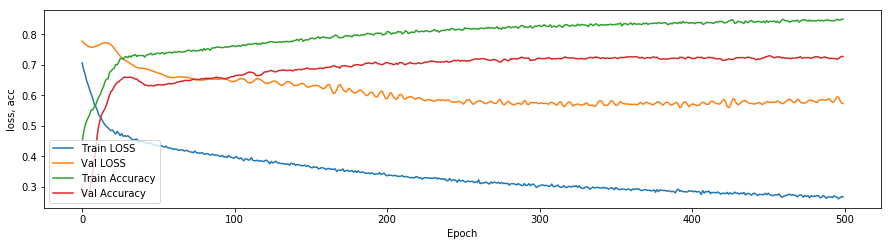

In [23]:
plot_history(_hist)

### Evaluation

In [24]:
model = keras.models.load_model(os.path.join('tb-logs', log_folder, 'bm.h5'), compile=False)

In [25]:
pred = np.around(model.predict(get_keras_dataset(test_df[FEATURE_COLS])))

print(accuracy_score(test_df[TARGET_COL], pred))
print(classification_report(test_df[TARGET_COL], pred))

0.7194312796208531
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       771
           1       0.49      0.71      0.58       284

   micro avg       0.72      0.72      0.72      1055
   macro avg       0.68      0.72      0.68      1055
weighted avg       0.77      0.72      0.73      1055

